In [1]:
import sys
import csv
import os
import shutil
import pandas as pd
import numpy as np
import decimal
from pyneuroml import pynml
from pyneuroml.pynml import print_comment_v
from pyneuroml.lems import LEMSSimulation

import neuroml as nml
import neuroml.writers as writers
from neuroml.utils import validate_neuroml2
import random
random.seed(12345)
from neuroml.nml.nml import parse as nmlparse
import eden_tools
dir(eden_tools)

import matplotlib
import matplotlib.pyplot as plt

os.getcwd()


/opt/conda/lib/python3.7/site-packages/airspeed/__init__.py:505: FutureWarning: Possible nested set at position 8
  KEYVALSEP = re.compile(r'[ \t]*:[[ \t]*(.*)$', re.S)


'/home/jovyan/work/NeuroML_Examples/Rocher'

## Big scale manual channel parameter exploration where you can choose which channel you want to examine

Ugly but functional code ¯\\_(ツ)_/¯ to set the parameters how you like. 
The morphologies are read from Another_Cells folder, parameters adjusted and then saved to the Cells folder which is used for running the simulations. This prevents you from overwriting/losing working parameters.



In [2]:
path = os.getcwd()
cell_id = 'C51A'
Temp = 37
net_id = "network_of_%s"%cell_id    
net_doc = nml.NeuroMLDocument(id='net_'+str(cell_id))
results = []
channel_dict = dict(na_s_soma=0, kdr_soma=1, k_soma=2, cal_soma=3, BK_soma=4, cah_dend=5, kca_dend=6, h_dend=7, cacc_dend=8, na_axon=9, k_axon=10)


In [3]:
#include cell file from ../Cells/
cellfile = nml.IncludeType(href='../Cells/'+cell_id+'_scaled_exp_resample_5.cell.nml')
net_doc.includes.append(cellfile)

#create network
net = nml.Network(id=net_id, type="networkWithTemperature", temperature=str(Temp)+"degC")
net_doc.networks.append(net)

#create population
pop = nml.Population(id='population_of_%s'%cell_id,component=cell_id,type='populationList',size='1')
net.populations.append(pop)

loc = nml.Location(x='0',y='0',z='0')
inst = nml.Instance(id='0',location=loc)
pop.instances.append(inst)

#include current clamp 
t_delay = 50
t_duration = 50
Amp = '-0.5nA'

Iclamp0 = nml.PulseGenerator(id='iclamp0',delay=str(t_delay)+'ms',duration=str(t_duration)+'ms', amplitude=Amp)
net_doc.pulse_generators.append(Iclamp0)

Iclamp1 = nml.PulseGenerator(id='iclamp1',delay=str(t_delay)+'ms',duration=str(t_duration)+'ms', amplitude=Amp)
net_doc.pulse_generators.append(Iclamp1)


#add Iclamp to cell
#input_list = nml.InputList(id='Iclamp0', component=Iclamp0.id, populations=pop.id)
#input = nml.Input(id='0', target = "../%s/0/"%(pop.id)+str(cell_id), segmentId="0", destination="synapses")
#input_list.input.append(input)
#net.input_lists.append(input_list)

#change segment_id to change the compartment you stimulate
input_list = nml.InputList(id='Iclamp1', component=Iclamp1.id, populations=pop.id)
input = nml.Input(id='0', target = "../%s/0/"%(pop.id)+str(cell_id), segmentId="69", destination="synapses")
input_list.input.append(input)
input = nml.Input(id='1', target = "../%s/0/"%(pop.id)+str(cell_id), segmentId="69", destination="synapses")
input_list.input.append(input)
net.input_lists.append(input_list)



#write the network file
net_file_name = 'nml_'+cell_id+'.net.nml'
writers.NeuroMLWriter.write(net_doc,net_file_name)
shutil.move(path+'/'+str(net_file_name), path+'/pynmlNetworks')






Error: Destination path '/home/jovyan/work/NeuroML_Examples/Rocher/pynmlNetworks/nml_C51A.net.nml' already exists

In [4]:
#this code section validates the generated files and prints the parameters set so far
validate_neuroml2('./pynmlNetworks/nml_'+cell_id+'.net.nml')


print('\nCell=' +str(cell_id))  
print('network=' +str(net_id)) 
print(pop.id, inst)
print(Iclamp0.id, 'delay='+str(t_delay), 'duration='+str(t_duration), 'Amplitude='+str(Amp))

Validating ./pynmlNetworks/nml_C51A.net.nml against /opt/conda/lib/python3.7/site-packages/neuroml/nml/NeuroML_v2.1.xsd
It's valid!

Cell=C51A
network=network_of_C51A
population_of_C51A Instance 0 at location: (0, 0, 0)
iclamp0 delay=50 duration=50 Amplitude=-0.5nA


In [5]:
#redefine net and cell in case you don't run the above code segment
sim_id = 'Test'
length = 10000
step = 0.025

dend_channel = ["cah_dend/cah/r/q", "kca_dend/kca/z/q", "h_dend/h/n/q", "cacc_dend/cacc/m/q"]
axon_channel = ["na_axon/na_a/m/q", "na_axon/na_a/h/q", "k_axon/k/n/q"]
soma_channel = ["na_s_soma/na_s/m/q", "na_s_soma/na_s/h/q", "kdr_soma/kdr/n/q", "k_soma/k/n/q", "cal_soma/cal/k/q", "cal_soma/cal/l/q", "BK_soma/BK/c/q"]
recorded_segment = 0
recorded_segment1 = 69
recorded_segment2 = 8
recorded_segment3 = 0
recorded_variable1 = "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment1)+"/v"
recorded_variable2 = "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment2)+"/v"
recorded_variable3 = "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment3)+"/v"

nmlfile = './pynmlNetworks/nml_'+cell_id+'.net.nml'  #include_neuroml2_file duplicates the path if you use path+ and does not find the file if you use ../
LEMS = LEMSSimulation(sim_id, length , step , target = "network_of_%s"%cell_id)
LEMS.include_neuroml2_file(nmlfile)
LEMS.set_report_file('SimStat.txt')                                   # not necessary but out of interest to see EDEN vs NEURON 




#disp_0 = 'Voltage'
#LEMS.create_display(disp_0, 'Voltage trace', '-100', '70' )
#LEMS.add_line_to_display(disp_0, recorded_segment, recorded_variable)

#traces0 = 'voltage traces'
#LEMS.create_output_file(traces0,"%s.v.dat"%sim_id)
#LEMS.add_column_to_output_file(traces0, recorded_segment, recorded_variable)
disp1 = 'Gates Dendrite'
disp2 = 'Gates Axon'
disp = 'Gates Soma'
traces1 = 'Gate_file_dendrite'
traces2 = 'Gate_file_axon'
traces = 'Gate_file_soma'

LEMS.create_display(disp, "Soma gate variables", "0", "1")
LEMS.create_output_file(traces, "%s.Soma_gates.dat"%sim_id)

LEMS.create_display(disp1, "Dendrite gate variables", "0", "1")
LEMS.create_output_file(traces1, "%s.Dendrite_gates.dat"%sim_id)

LEMS.create_display(disp2, "Axon gate variables", "0", "1")
LEMS.create_output_file(traces2, "%s.Axon_gates.dat"%sim_id)

for i in range(len(dend_channel)):
    #disp1 = 'Gates Dendrite'
    #LEMS.create_display(disp1, "Dendrite gate variables", "0", "1")
    LEMS.add_line_to_display(disp1, recorded_segment1, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment1)+"/biophys/membraneProperties/"+str(dend_channel[i]))

    #traces1 = 'Gate_file_dendrite'
    #LEMS.create_output_file(traces1, "%s.gates.dat"%sim_id)
    LEMS.add_column_to_output_file(traces1, recorded_segment1, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment1)+"/biophys/membraneProperties/"+str(dend_channel[i]))
    
for i in range(len(axon_channel)):
    #disp2 = 'Gates Axon'
    #LEMS.create_display(disp1, "Dendrite gate variables", "0", "1")
    LEMS.add_line_to_display(disp2, recorded_segment2, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment2)+"/biophys/membraneProperties/"+str(axon_channel[i]))

    #traces2 = 'Gate_file_axon'
    #LEMS.create_output_file(traces1, "%s.gates.dat"%sim_id)
    LEMS.add_column_to_output_file(traces2, recorded_segment2, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment2)+"/biophys/membraneProperties/"+str(axon_channel[i]))   
    
for i in range(len(soma_channel)):
    #disp2 = 'Gates Axon'
    #LEMS.create_display(disp1, "Dendrite gate variables", "0", "1")
    LEMS.add_line_to_display(disp, recorded_segment, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment)+"/biophys/membraneProperties/"+str(soma_channel[i]))

    #traces2 = 'Gate_file_axon'
    #LEMS.create_output_file(traces1, "%s.gates.dat"%sim_id)
    LEMS.add_column_to_output_file(traces, recorded_segment, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment)+"/biophys/membraneProperties/"+str(soma_channel[i]))        
    


disp4 = 'Voltage'
LEMS.create_display(disp4, "Dendrite trace", "-100", "70")
LEMS.add_line_to_display(disp4, recorded_segment1, recorded_variable1)
LEMS.add_line_to_display(disp4, recorded_segment2, recorded_variable2)
LEMS.add_line_to_display(disp4, recorded_segment3, recorded_variable3)

traces4 = 'file'
LEMS.create_output_file(traces4, "%s.vd.dat"%sim_id)
LEMS.add_column_to_output_file(traces4, recorded_segment1, recorded_variable1)
LEMS.add_column_to_output_file(traces4, recorded_segment2, recorded_variable2)
LEMS.add_column_to_output_file(traces4, recorded_segment3, recorded_variable3)

disp5 = 'Caconc'
LEMS.create_display(disp5, "Caconc trace", "-100", "70")
LEMS.add_line_to_display(disp5, recorded_segment1, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(69)+"/caConc")

traces5 = 'Caconc file'
LEMS.create_output_file(traces5, "%s.caconc.dat"%sim_id)
LEMS.add_column_to_output_file(traces5, recorded_segment1, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(69)+"/caConc")


#disp5 = 'Calcium Concentration'
#LEMS.create_display(disp5, "Calcium concentration", "0", "1")
#LEMS.add_line_to_display(disp, recorded_segment, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment)+"/caConc")

#traces5 = 'Ca conc file'
#LEMS.create_output_file(traces5, "%scalconc.dat"%sim_id)
#LEMS.add_column_to_output_file(traces5, recorded_segment, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment)+"/caConc")        
    






filename = 'LEMS_'+str(sim_id)+'_'+str(cell_id)+'.xml'
LEMS.save_to_file(file_name = filename )

#edit the wrong path generated by LEMS.include_neuroml2_file
fin = open(path+'/'+str(filename), 'rt')
data = fin.read()
data = data.replace('<Include file="./pynmlNetworks/', '<Include file="../pynmlNetworks/')
data = data.replace('ExpTime.nml', '../channels/ExpTime.nml')    # patch up for wrong path generated in network script
fin.close()
fin = open(path+'/'+str(filename), 'wt')
fin.write(data)
fin.close()

shutil.move(path+'/'+str(filename), path+'/LEMSFILES')


pyNeuroML >>> Written LEMS Simulation Test to file: LEMS_Test_C51A.xml


Error: Destination path '/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES/LEMS_Test_C51A.xml' already exists

# Choose parameters

In [6]:

#Set somatic channel densities
na_s_soma =[30,30,30,30,30]   #default 30
kdr_soma=[30,30,30,30,30]     #default 30
k_soma=[15,15,15,15,15]       #default 15
cal_soma=[60,60,60,60,60]     #default 20
BK_soma=[0,0,0,0,0]       #default 0 :) 

#set dendritic channel densities
cah_dend=[10,10,10,10,10]     #default 10
kca_dend=[130,132,134,136,138]     #default 35
h_dend=[25,25,25,25,25]       #default 25
cacc_dend = [0,0,0,0,0] #default 0.7

#set axonic channel densities
na_axon=[100,100,100,100,100]     #default 200
k_axon=[200,200,200,200,200]      #default 200

#set leak conductance
#leak=[]


results = []
LEMS_file = f'LEMSFILES/{filename}'

for g in range(len(na_s_soma)):

    doc = nmlparse('Another_Cells/'+cell_id+'_scaled_exp_resample_5.cell.nml')
    
    #somatic channel densities
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['na_s_soma']].cond_density = str(na_s_soma[g])+' mS_per_cm2'
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['kdr_soma']].cond_density = str(kdr_soma[g])+' mS_per_cm2'
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['k_soma']].cond_density = str(k_soma[g])+' mS_per_cm2'
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['cal_soma']].cond_density = str(cal_soma[g])+' mS_per_cm2'
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['BK_soma']].cond_density = str(BK_soma[g])+' mS_per_cm2'
    
    #dendritic channel densities    
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['cah_dend']].cond_density = str(cah_dend[g])+' mS_per_cm2'
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['kca_dend']].cond_density = str(kca_dend[g])+' mS_per_cm2'    
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['h_dend']].cond_density = str(h_dend[g])+' mS_per_cm2'
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['cacc_dend']].cond_density = str(cacc_dend[g])+' mS_per_cm2'
    
    #axonic channel densities
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['na_axon']].cond_density = str(na_axon[g])+' mS_per_cm2'
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['k_axon']].cond_density = str(k_axon[g])+' mS_per_cm2'
    
    #leak channel
    #doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['leak']].cond_density = str(leak[g])+' mS_per_cm2'
    writers.NeuroMLWriter.write(doc, 'Cells/'+cell_id+'_scaled_exp_resample_5.cell.nml')

 

    #out_dir = path+'\Simulation result'
    out_dir,rel_filename = os.path.split(LEMS_file)
    print(out_dir)
    print(rel_filename)



    print(f'You are running a simulation of {LEMS_file} and saving the results to {out_dir}\n')

    #results = {}
    #results = pynml.run_lems_with_jneuroml_neuron(
    #        LEMS_file, verbose=False, nogui=True, load_saved_data=True, exec_in_dir= out_dir,
    #        max_memory='1000M')


    LEMS_file = f'LEMSFILES/{filename}'
    #results_Eden = eden_tools.runEden( LEMS_file, verbose=True )
    results_Neuron = eden_tools.runNeuron( LEMS_file, verbose=True )
    results.append(dict(results_Neuron))

LEMSFILES
LEMS_Test_C51A.xml
You are running a simulation of LEMSFILES/LEMS_Test_C51A.xml and saving the results to LEMSFILES

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMS_Test_C51A.xml), base_dir: LEMSFILES, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 15.44 seconds
LEMSFILES
LEMS_Test_C51A.xml
You are running a simulation of LEMSFILES/LEMS_Test_C51A.xml and saving the results to LEMSFILES

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMS_Test_C51A.xml), base_dir: LEMSFILES, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 14.70 seconds
LEMSFILES
LEMS_Test_C51A.xml
You are running a simulation of LEMSFILES/LEMS_Test_C51A.xml and saving the results to LEMSFILES

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMS_Test_C51A.xml), b

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


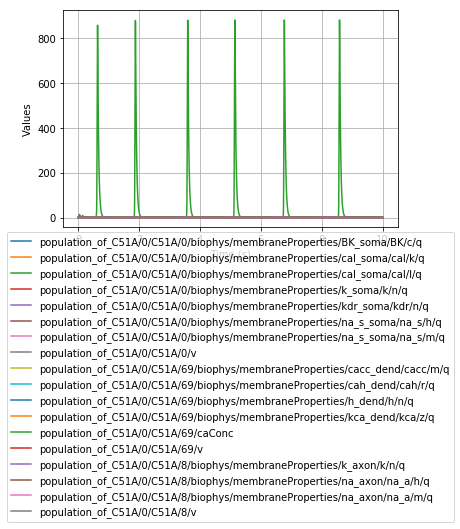

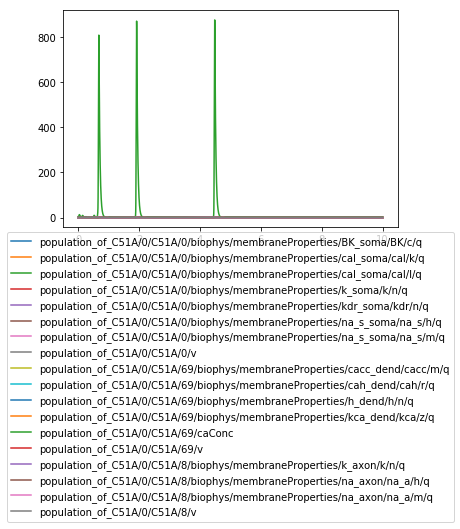

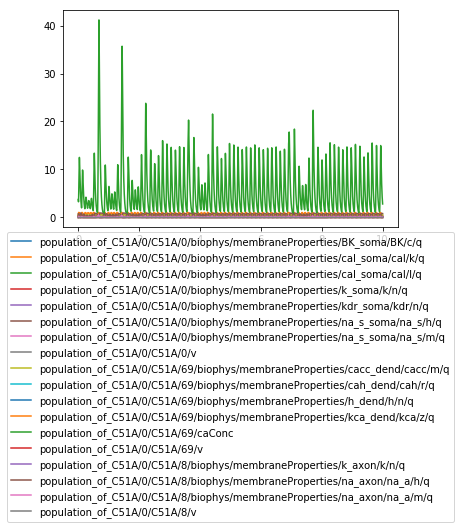

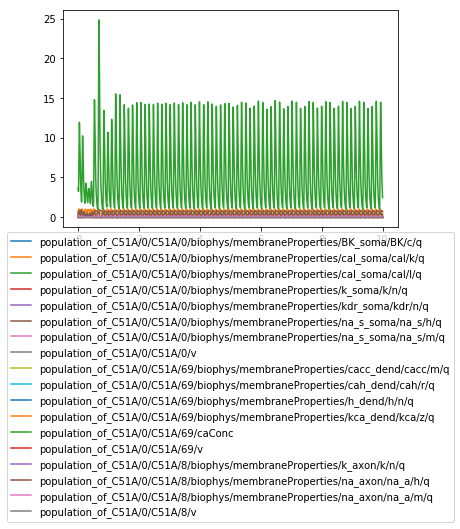

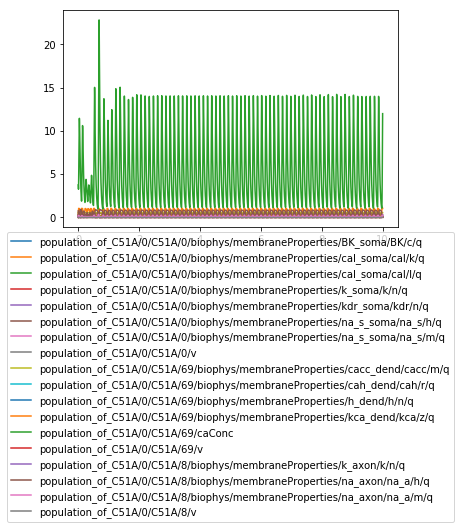

In [7]:

plt.xlabel('Time (s)')
plt.ylabel('Values')
plt.grid(True)

# plt.gca().clear()

for i in range(len(results)):

    for key in results[i]:
        results_Neuron = results[i]
        if key == 't':
            # no need to plot sim time against sim time
            continue
        plt.plot(results_Neuron['t'],results_Neuron[key], label=""+key)

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0))
    plt.show()


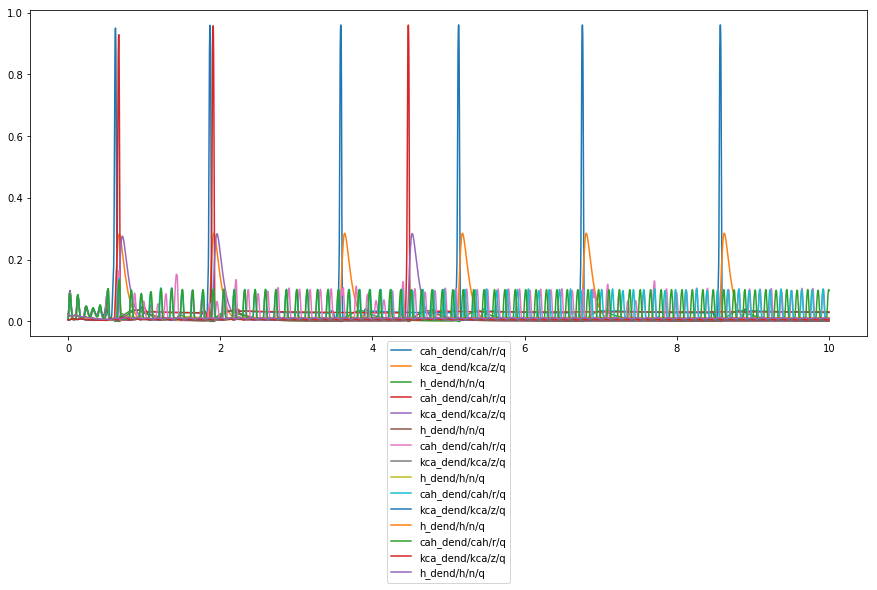

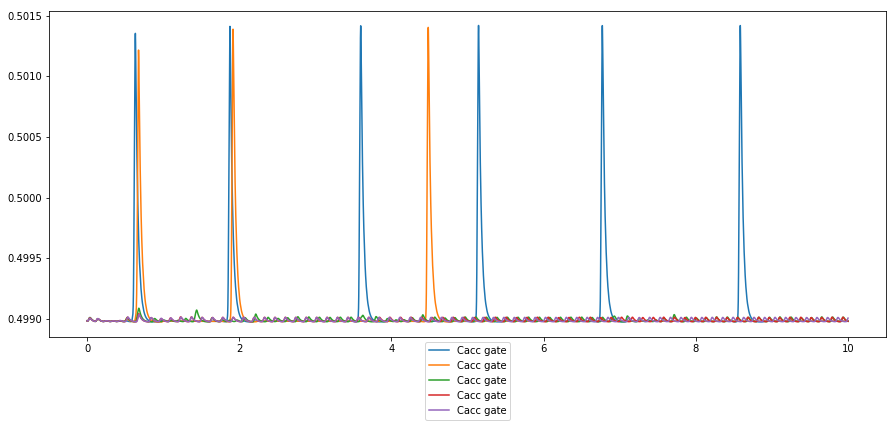

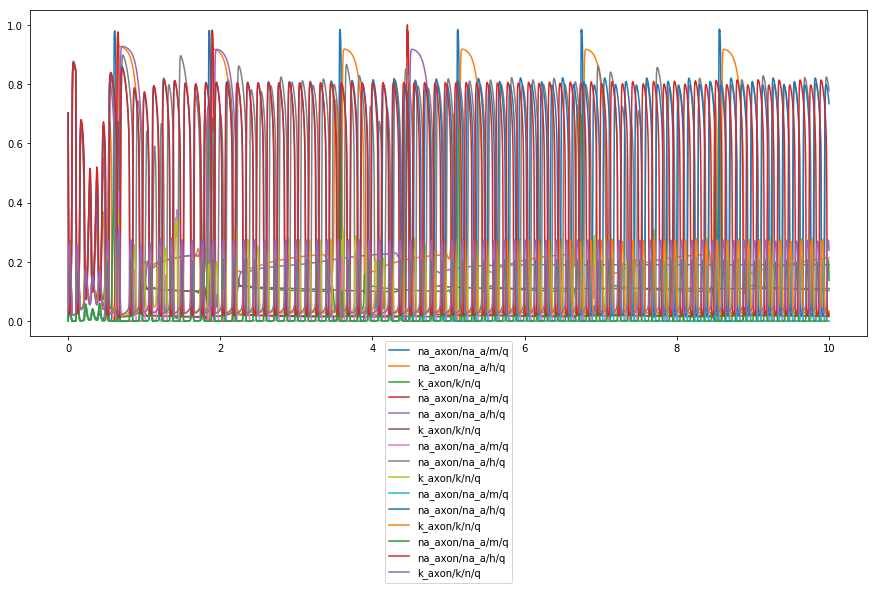

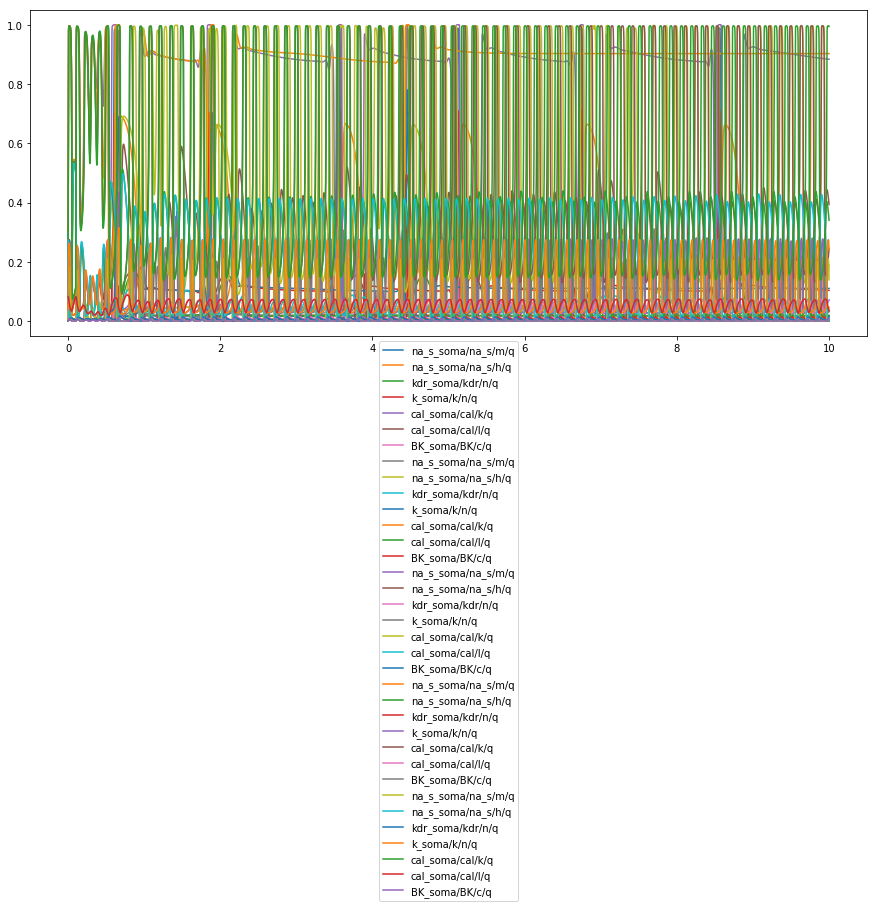

In [8]:
for g in range(len(results)):
    results_Neuron = results[g]
    plt.figure(1, figsize=(15,6))
    for i in range(3):
        #ax2.plot(results_Neuron['t'],results_Neuron['population_of_C51A/0/C51A/10/biophys/membraneProperties/iCa'], label=""+key)
        plt.plot(results_Neuron['t'],results_Neuron[f'population_of_{cell_id}/0/{cell_id}/69/biophys/membraneProperties/'+str(dend_channel[i])], label=str(dend_channel[i]))
    #plt.plot(results_Neuron['t'],results_Neuron['population_of_C51A/0/C51A/10/biophys/membraneProperties/'+str(dend_channel[3])], label=""+key)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0))
        

    plt.figure(2, figsize=(15,6))
    plt.plot(results_Neuron['t'],results_Neuron[f'population_of_{cell_id}/0/{cell_id}/69/biophys/membraneProperties/'+str(dend_channel[3])], label="Cacc gate")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0))
     

    plt.figure(3, figsize=(15,6))
    for i in range(len(axon_channel)):
        plt.plot(results_Neuron['t'], results_Neuron[f'population_of_{cell_id}/0/{cell_id}/8/biophys/membraneProperties/'+str(axon_channel[i])], label=str(axon_channel[i]))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0))
     


    plt.figure(4, figsize=(15,6))
    for i in range(len(soma_channel)):
        plt.plot(results_Neuron['t'],results_Neuron[f'population_of_{cell_id}/0/{cell_id}/0/biophys/membraneProperties/'+str(soma_channel[i])], label=str(soma_channel[i]))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0))
plt.show()     

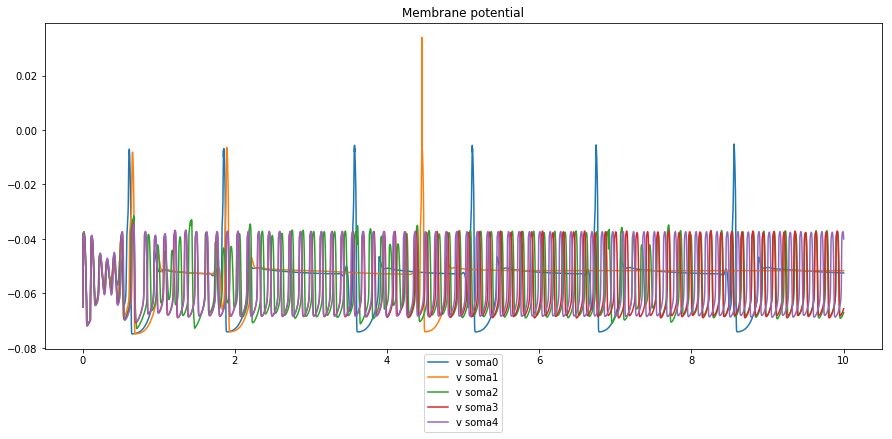

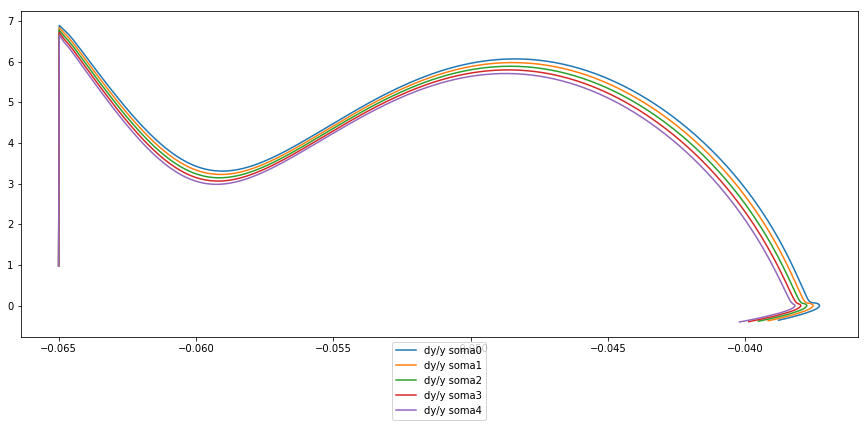

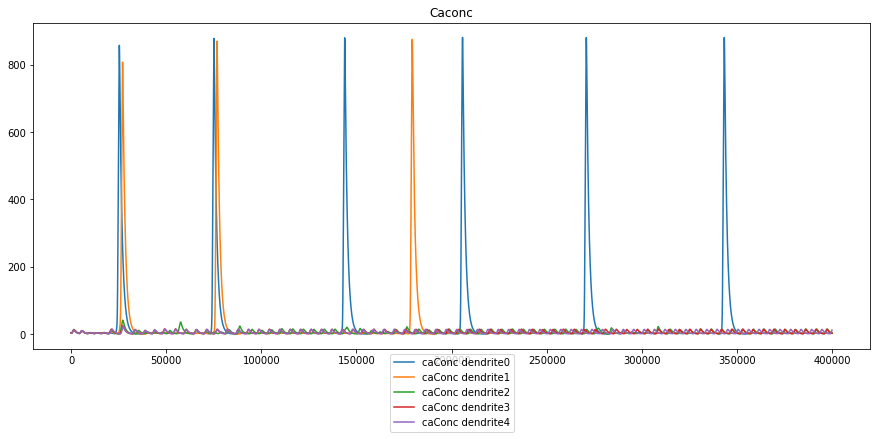

In [9]:
from numpy import diff
for g in range(len(results)):
    results_Neuron = results[g]
    plt.figure(5, figsize=(15,6))
    plt.plot(results_Neuron['t'], results_Neuron[f'population_of_{cell_id}/0/{cell_id}/0/v'], label = "v soma"+str(g))
    #plt.plot(results_Neuron['t'], results_Neuron['population_of_C15A/0/C15A/10/v'], label = "v dendrite")
    #plt.plot(results_Neuron['t'], results_Neuron['population_of_C15A/0/C15A/69/v'], label ="v axon")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0))
    plt.title('Membrane potential')
plt.show() 


plt.figure(6, figsize=(15,6))

for g in range(len(results)):
    dx = 0.025*(10**-3)
    results_Neuron = results[g]
    y = results_Neuron[f'population_of_{cell_id}/0/{cell_id}/0/v']
    dy = diff(y)/dx
    plt.plot(y[0:1000],dy[0:1000], label = "dy/y soma"+str(g))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0))
    
    
plt.show() 

plt.figure(7, figsize=(15,6))
for g in range(len(results)):
    results_Neuron = results[g]
    plt.plot(results_Neuron[f'population_of_{cell_id}/0/{cell_id}/69/caConc'], label = "caConc dendrite"+str(g))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0))
    
    plt.title('Caconc')
plt.savefig('caconc.png')    
plt.show() 


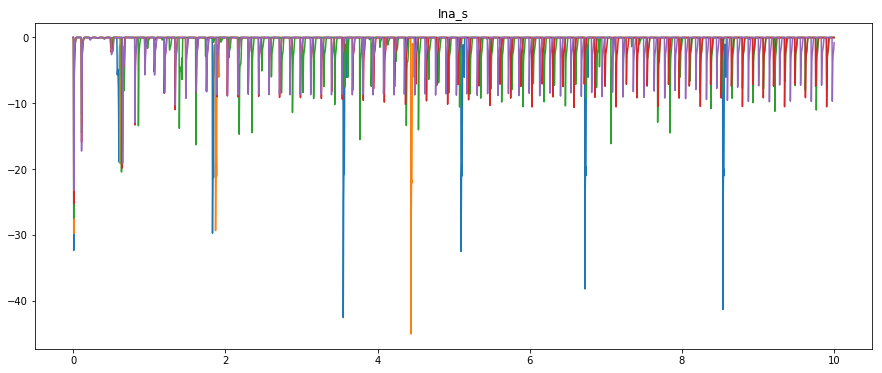

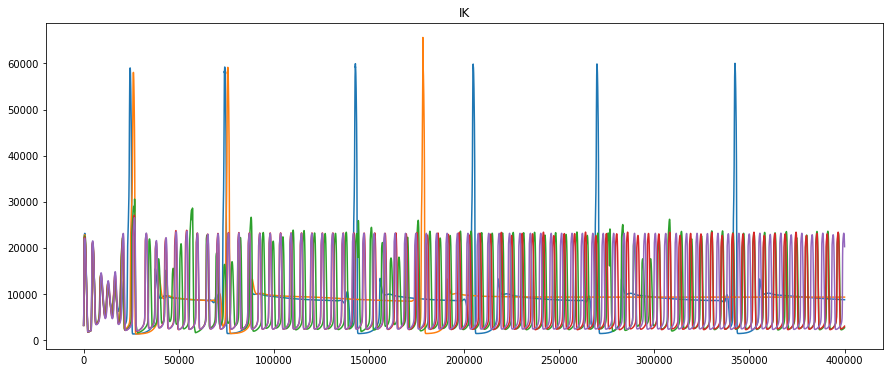

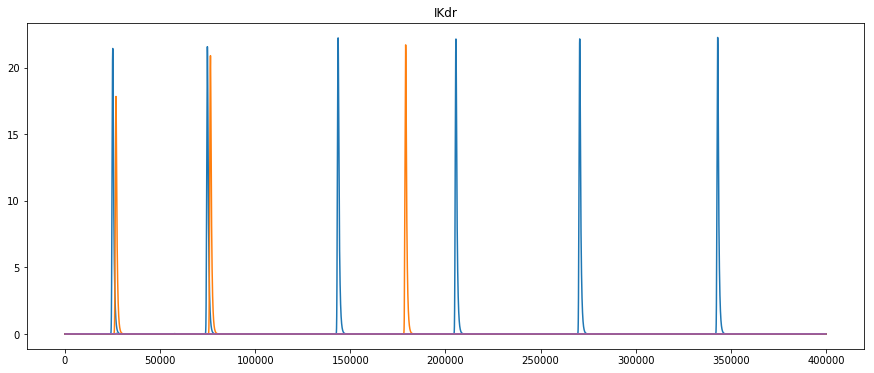

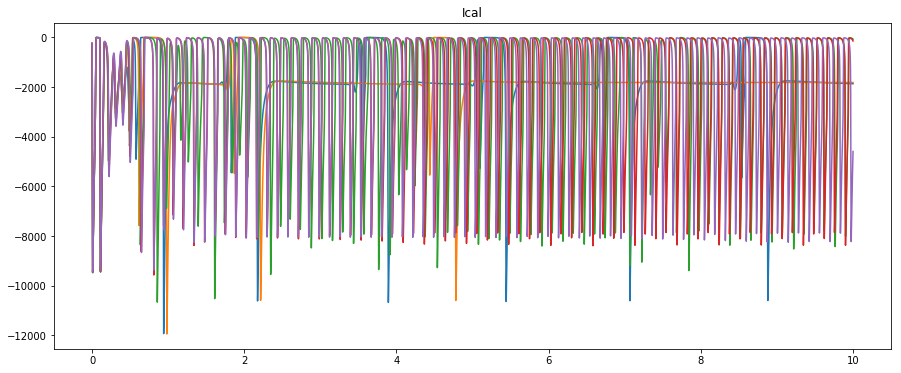

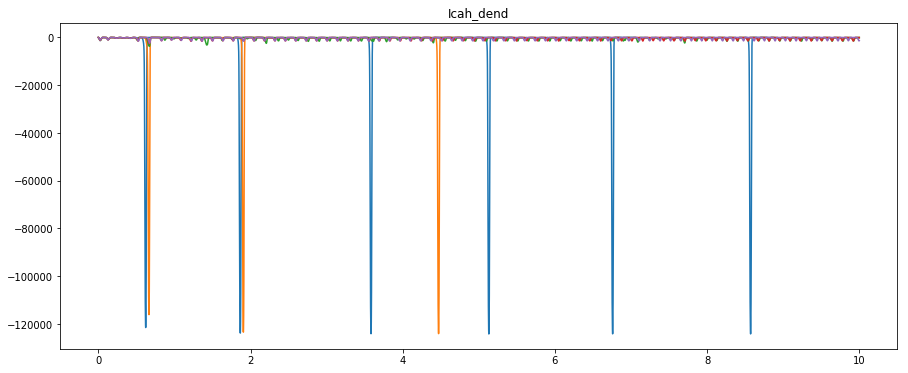

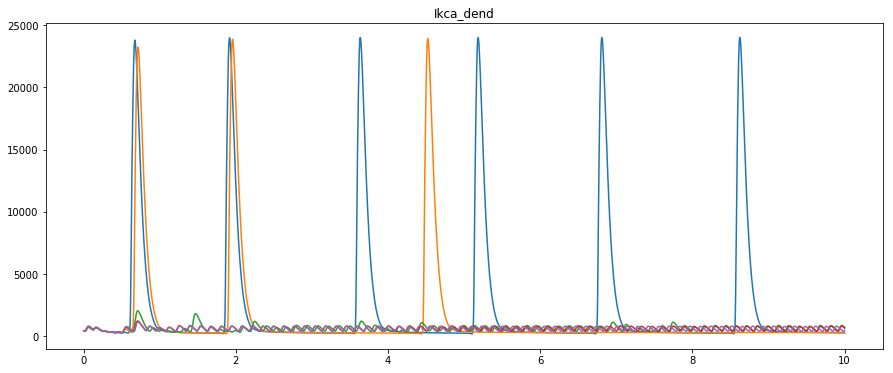

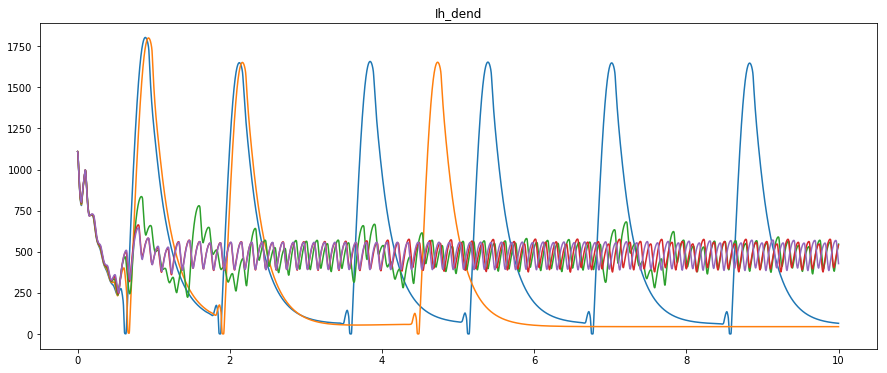

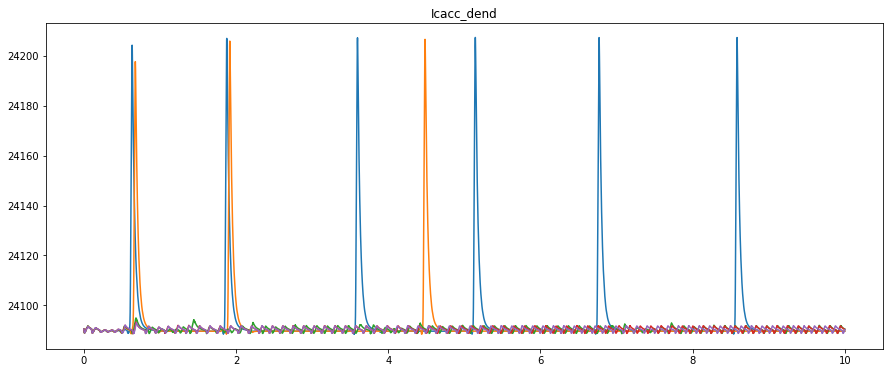

In [10]:
dend_channel = ["cah_dend/cah/r/q", "kca_dend/kca/z/q", "h_dend/h/n/q", "cacc_dend/cacc/m/q"]
axon_channel = ["na_axon/na_a/m/q", "na_axon/na_a/h/q", "k_axon/k/n/q"]
soma_channel = ["na_s_soma/na_s/m/q", "na_s_soma/na_s/h/q", "kdr_soma/kdr/n/q", "k_soma/k/n/q", "cal_soma/cal/k/q", "cal_soma/cal/l/q", "BK_soma/BK/c/q"]

for g in range(len(results)):
    results_Neuron = results[g]
    #SOMATIC CURRENTS
    t = results_Neuron['t']
    g_bar = 10 *10^-12
    v = results_Neuron[f'population_of_{cell_id}/0/{cell_id}/0/v']
    E_na_s = 55 *10^-3
    plt.figure(8, figsize=(15,6))
    vna_s = [x - E_na_s for x in v]
    m = results_Neuron[f'population_of_{cell_id}/0/{cell_id}/0/biophys/membraneProperties/na_s_soma/na_s/m/q']
    h = results_Neuron[f'population_of_{cell_id}/0/{cell_id}/0/biophys/membraneProperties/na_s_soma/na_s/h/q']
    gate_na_s = [a * a * a * b for a, b in zip(m, h)]
    Inas = [x * g_bar for x in gate_na_s]
    Inas = [a * b for a, b in zip(vna_s, Inas)]
    plt.plot(t,Inas)
    plt.title('Ina_s')





    E_k = -75 *10^-3         
    g_bar = 10 *10^-12
    plt.figure(9, figsize=(15,6))
    nk = results_Neuron[f'population_of_{cell_id}/0/{cell_id}/0/biophys/membraneProperties/k_soma/k/n/q']
    #Ik = g*n
    vk = [x - E_k for x in v]
    Ik = [x * g_bar for x in nk]
    Ik = [a * b for a, b in zip(vk, Ik)]
    plt.plot(Ik)
    plt.title('IK')

    E_kdr = -75 *10^-3         
    plt.figure(10, figsize=(15,6))
    n = results_Neuron[f'population_of_{cell_id}/0/{cell_id}/0/biophys/membraneProperties/kdr_soma/kdr/n/q']
    #Ik = g*n
    vkdr = [x - E_kdr for x in v]
    Ikdr = [x * x * x * x * g_bar for x in n]
    Ikdr = [a * b for a, b in zip(vkdr, Ikdr)]
    plt.plot(Ikdr)
    plt.title('IKdr')


    g_cal = 10 *10^-12
    E_cal = 120 *10^-3
    plt.figure(11, figsize=(15,6))
    v = results_Neuron[f'population_of_{cell_id}/0/{cell_id}/0/v']
    vcal = [x - E_cal for x in v]
    k = results_Neuron[f'population_of_{cell_id}/0/{cell_id}/0/biophys/membraneProperties/cal_soma/cal/k/q']
    l = results_Neuron[f'population_of_{cell_id}/0/{cell_id}/0/biophys/membraneProperties/cal_soma/cal/l/q']
    #Ical = k*k*k*l
    gate_cal = [a * a * a * b for a, b in zip(k, l)]
    Ical = [x * g_cal for x in gate_cal]
    Ical = [a * b for a, b in zip(vcal, Ical)]
    plt.plot(t,Ical)
    plt.title('Ical')

    #DENDRITIC CURRENTS
    plt.figure(12, figsize=(15,6))
    v = results_Neuron[f'population_of_{cell_id}/0/{cell_id}/69/v']
    E_cah_dend = 120 *10^-3
    #I_CaH  =  g_CaH * r * r * (V_dend - V_Ca)
    vcah_dend = [x - E_cah_dend for x in v]
    r = results_Neuron[f'population_of_{cell_id}/0/{cell_id}/69/biophys/membraneProperties/cah_dend/cah/r/q']
    gate_cahdend = [a * a * b for a, b in zip(r, vcah_dend)]
    Icah_dend = [x * g_bar for x in gate_cahdend]
    plt.plot(t,Icah_dend)
    plt.title('Icah_dend')

    plt.figure(12, figsize=(15,6))
    v = results_Neuron[f'population_of_{cell_id}/0/{cell_id}/69/v']
    E_kca_dend = -75 *10^-3
    plt.figure(13, figsize=(15,6))
    vkca_dend = [x - E_kca_dend for x in v]
    r = results_Neuron[f'population_of_{cell_id}/0/{cell_id}/69/biophys/membraneProperties/kca_dend/kca/z/q']
    gate_kcadend = [a * b for a, b in zip(r, vkca_dend)]
    Ikca_dend = [x * g_bar for x in gate_kcadend]
    plt.plot(t,Ikca_dend)
    plt.title('Ikca_dend')


    plt.figure(12, figsize=(15,6))
    v = results_Neuron[f'population_of_{cell_id}/0/{cell_id}/69/v']
    E_h_dend = -43 *10^-3
    plt.figure(14, figsize=(15,6))
    vh_dend = [x - E_h_dend for x in v]
    n = results_Neuron[f'population_of_{cell_id}/0/{cell_id}/69/biophys/membraneProperties/h_dend/h/n/q']
    gate_hdend = [a * b for a, b in zip(n, vh_dend)]
    Ih_dend = [x * g_bar for x in gate_hdend]
    plt.plot(t,Ih_dend)
    plt.title('Ih_dend')    

    plt.figure(12, figsize=(15,6))
    v = results_Neuron[f'population_of_{cell_id}/0/{cell_id}/69/v']
    E_cacc_dend = -45 *10^-3
    plt.figure(15, figsize=(15,6))
    vcacc_dend = [x - E_h_dend for x in v]
    m = results_Neuron[f'population_of_{cell_id}/0/{cell_id}/69/biophys/membraneProperties/cacc_dend/cacc/m/q']
    gate_caccdend = [a * b for a, b in zip(m, vcacc_dend)]
    Icacc_dend = [x * g_bar for x in gate_caccdend]
    plt.plot(t,Icacc_dend)
    plt.title('Icacc_dend')

plt.show() 

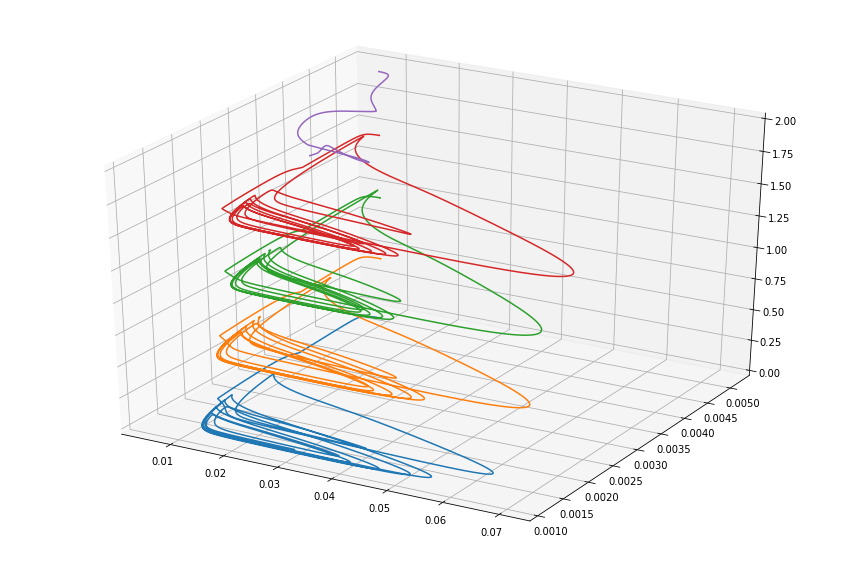

In [96]:
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

x = []
y = []
z = []
for g in range(len(results)):
    x.append(results[g][f'population_of_{cell_id}/0/{cell_id}/69/biophys/membraneProperties/cah_dend/cah/r/q'])
    y.append(results[g][f'population_of_{cell_id}/0/{cell_id}/69/biophys/membraneProperties/kca_dend/kca/z/q'])
    z.append(np.ones((len(x[0])))*g*0.5)

plt.figure(figsize=(15,10))
ax = plt.subplot(projection='3d')

for g in range(len(results)):    
    ax.plot(x[g], y[g], z[g])



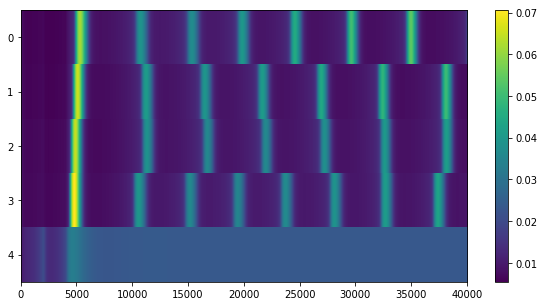

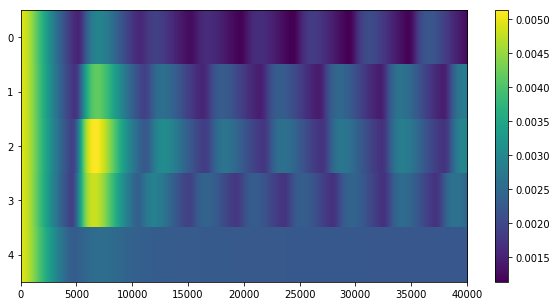

In [97]:
plt.figure(figsize=(10,5))
plt.imshow(x, interpolation='none', aspect='auto')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,5))
plt.imshow(y, interpolation='none', aspect='auto')
plt.colorbar()
plt.show()

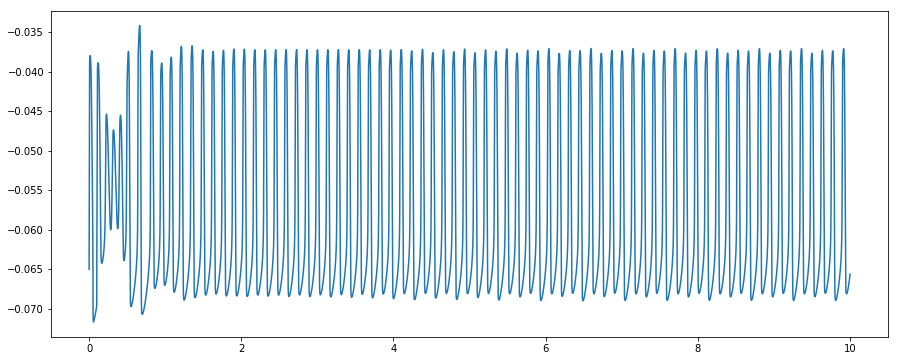

In [19]:
g=3
results_Neuron = results[g]
plt.figure(5, figsize=(15,6))
plt.plot(results_Neuron['t'], results_Neuron[f'population_of_{cell_id}/0/{cell_id}/0/v'], label = "v soma"+str(g))
#plt.plot(results_Neuron['t'], results_Neuron['population_of_C15A/0/C15A/10/v'], label = "v dendrite")

In [70]:
os.remove(nmlfile)
os.remove(LEMS_file)

In [ ]:
import json
with open('Caconc_new', 'w') as fout:
    json.dump(results_Neuron[f'population_of_{cell_id}/0/{cell_id}/8/caConc'], fout)